In [3]:
# !pip install mlflow dagshub
import zipfile
import os
import itertools
import matplotlib.pylab as plt
import mlflow
import mlflow.keras
import dagshub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Activation,BatchNormalization,Dropout,Flatten,Conv2D,MaxPooling2D,GlobalAveragePooling2D

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Navigate to your dataset in Google Drive
dataset_path = '/content/drive/MyDrive/Human_Action_Recognition.zip'

# Extract the dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset/')

dataset_path = '/content/dataset/'
print("Root contents:", os.listdir(dataset_path))

# Explore the structured folder
structured_path = '/content/dataset/Structured'
print("\nStructured folder contents:", os.listdir(structured_path))

# Check train and test folders
train_path = os.path.join(structured_path, 'train')
test_path = os.path.join(structured_path, 'test')

print(f"\nTrain folder contents: {os.listdir(train_path)}")
print(f"Test folder contents: {os.listdir(test_path)}")

Root contents: ['Structured']

Structured folder contents: ['train', 'test']

Train folder contents: ['texting', 'eating', 'calling', 'drinking', 'fighting', 'laughing', 'running', 'cycling', 'dancing', 'listening_to_music', 'clapping', 'sleeping', 'using_laptop', 'sitting', 'hugging']
Test folder contents: ['texting', 'eating', 'calling', 'drinking', 'fighting', 'laughing', 'running', 'cycling', 'dancing', 'listening_to_music', 'clapping', 'sleeping', 'using_laptop', 'sitting', 'hugging']


In [6]:
def generate_hyperparameter():

  img_size=[64,128,224]
  batch_size=[16,32,64]
  learning_rates = [0.001, 0.0001]
  hidden_nodes=[128,256,512]

  config=[
      # Smaller Network:
      {"hidden_nodes":128,"img_size":64,"batch_size":16,"learning_rate":0.001},
      {"hidden_nodes":128,"img_size":128,"batch_size":32,"learning_rate":0.001},

      # Medium Network:
      {"hidden_nodes":256,"img_size":128,"batch_size":32,"learning_rate":0.001},
      {"hidden_nodes":256,"img_size":224,"batch_size":64,"learning_rate":0.0001},

      # Larger Network:
      {"hidden_nodes":512,"img_size":128,"batch_size":32,"learning_rate":0.0001},
      {"hidden_nodes":512,"img_size":224,"batch_size":64,"learning_rate":0.0001},

      # Other Larger network:
      {"hidden_nodes":512,"img_size":224,"batch_size":16,"learning_rate":0.001},
      {"hidden_nodes":512,"img_size":224,"batch_size":32,"learning_rate":0.001},

  ]
  return config


In [7]:
def create_action_recognition_dataset(img_size=128, batch=32):
    structured_path = '/content/dataset/Structured'
    train_path = os.path.join(structured_path, 'train')
    test_path = os.path.join(structured_path, 'test')

    # Automatically discover class names from train folder
    CLASS_NAMES = sorted(os.listdir(train_path))
    print("Discovered action classes:", CLASS_NAMES)

    # Create datasets using Keras
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_path,
        labels='inferred',
        label_mode='int',
        class_names=CLASS_NAMES,
        image_size=(img_size, img_size),
        batch_size=batch,
        shuffle=True
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_path,
        labels='inferred',
        label_mode='int',
        class_names=CLASS_NAMES,
        image_size=(img_size, img_size),
        batch_size=batch,
        shuffle=False
    )

    def preprocess(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    train_dataset = train_dataset.map(preprocess)
    test_dataset = test_dataset.map(preprocess)

    return train_dataset, test_dataset, CLASS_NAMES

In [8]:
train_dataset, test_dataset, CLASS_NAMES = create_action_recognition_dataset()

print(f"\nDataset created successfully!")
print(f"Number of classes: {len(CLASS_NAMES)}")
print(f"Classes: {CLASS_NAMES}")
print(f"Train batches: {len(train_dataset)}")
print(f"Test batches: {len(test_dataset)}")

Discovered action classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Found 10710 files belonging to 15 classes.
Found 1890 files belonging to 15 classes.

Dataset created successfully!
Number of classes: 15
Classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Train batches: 335
Test batches: 60


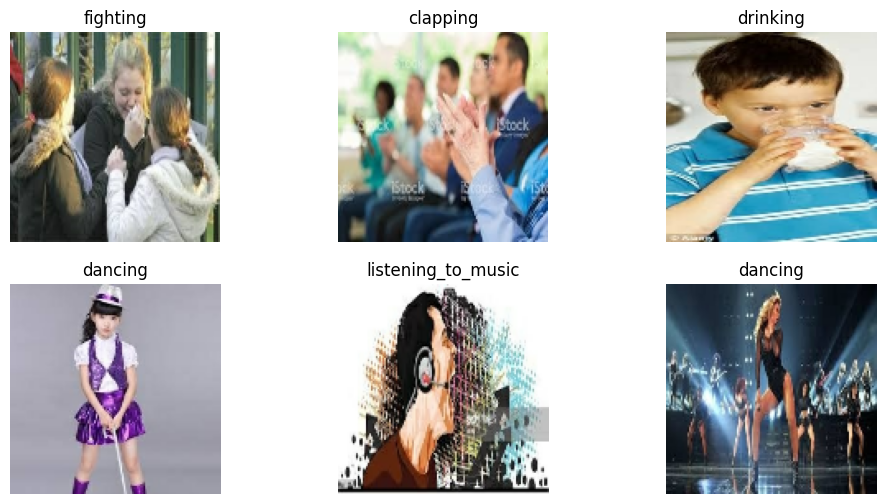

In [9]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        display_image = (images[i].numpy() * 255).astype("uint8")

        plt.imshow(display_image)
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis('off')
    plt.show()

In [10]:
def plot_training(history):
    """Simple plot function"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()

    plt.show()

In [11]:
DAGSHUB_USERNAME = "Arej02"
DAGSHUB_REPO_NAME = "Human_Action_Recognition"

# Setup DagsHub connection
dagshub.init(repo_owner=DAGSHUB_USERNAME, repo_name=DAGSHUB_REPO_NAME,mlflow=True)

# Set MLflow tracking to DagsHub
mlflow.set_tracking_uri(f"https://dagshub.com/Arej02/Human_Action_Recognition.mlflow")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=055b73fb-2cdc-4306-8630-0e585504f50d&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=2c5fb4b32194711a4c6d58b50fb75b4c56a830b8021d11cb3332539b7502521d




Output()

Accessing as Arej02

Initialized MLflow to track repo "Arej02/Human_Action_Recognition"

Repository Arej02/Human_Action_Recognition initialized!

In [12]:
mlflow.set_experiment("Hyperparameter Tuning")

<Experiment: artifact_location='mlflow-artifacts:/e76e81c32c73489cac0b1616c9ec1f2e', creation_time=1764316109483, experiment_id='1', last_update_time=1764316109483, lifecycle_stage='active', name='Hyperparameter Tuning', tags={}>

In [13]:
def train_action_recognition():
  configs=generate_hyperparameter()

  best_accuracy=0
  best_hyperparameter=None

  for i,config in enumerate(configs):

    with mlflow.start_run(run_name="hyperaprameter tuning v1"):
      mlflow.log_params(config)

      train_dataset,test_dataset,CLASS_NAME=create_action_recognition_dataset(img_size=config['img_size'],batch=config['batch_size'])

      model=Sequential([
          # Layer 1:
          Conv2D(32, (3,3), activation="relu"),
          MaxPooling2D((2,2)),

          # Layer 2:
          Conv2D(128,(3,3),activation="relu"),
          MaxPooling2D((2,2)),

          # Layer 2:
          Conv2D(256,(3,3),activation="relu"),
          MaxPooling2D((2,2)),

          GlobalAveragePooling2D(),

          Dense(config["hidden_nodes"]),
          BatchNormalization(),
          Activation("relu"),
          Dropout(0.5),

          Dense(config["hidden_nodes"]),
          BatchNormalization(),
          Activation("relu"),
          Dropout(0.5),

          Dense(len(CLASS_NAME),activation="softmax")
      ])

      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])

      history=model.fit(
          train_dataset,
          validation_data=test_dataset,
          epochs=10,
          verbose=1
      )

      final_train_accuracy=history.history["accuracy"][-1] #Last epoch
      final_test_accuracy=history.history["val_accuracy"][-1]
      final_train_loss=history.history["loss"][-1]
      final_test_loss=history.history["val_loss"][-1]

      mlflow.log_metric("Train Accuracy:",final_train_accuracy)
      mlflow.log_metric("Test Accuracy:",final_test_accuracy)
      mlflow.log_metric("Train Loss:",final_train_loss)
      mlflow.log_metric("Test Loss:",final_test_loss)

      best_val_accuracy = max(history.history["val_accuracy"])
      mlflow.log_metric("best_val_accuracy", best_val_accuracy)

      if final_test_accuracy>best_accuracy:
        best_accuracy=final_test_accuracy
        best_config=config

      plot_training(history)

      return best_config,best_accuracy



Discovered action classes: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']
Found 10710 files belonging to 15 classes.
Found 1890 files belonging to 15 classes.
Epoch 1/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 163s 236ms/step - accuracy: 0.0977 - loss: 2.9956 - val_accuracy: 0.1196 - val_loss: 2.8168
Epoch 2/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 151s 225ms/step - accuracy: 0.1410 - loss: 2.6190 - val_accuracy: 0.1561 - val_loss: 2.5154
Epoch 3/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 148s 221ms/step - accuracy: 0.1689 - loss: 2.4959 - val_accuracy: 0.1545 - val_loss: 2.5086
Epoch 4/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 151s 225ms/step - accuracy: 0.1959 - loss: 2.4097 - val_accuracy: 0.1725 - val_loss: 2.4634
Epoch 5/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 149s 223ms/step - accuracy: 0.2118 - loss: 2.3562 - val_accuracy: 0.2101 - val_loss: 2.3721
Epoch 6/10
670/670 ━━━━━━━━━━━━━━━━━━━━ 15

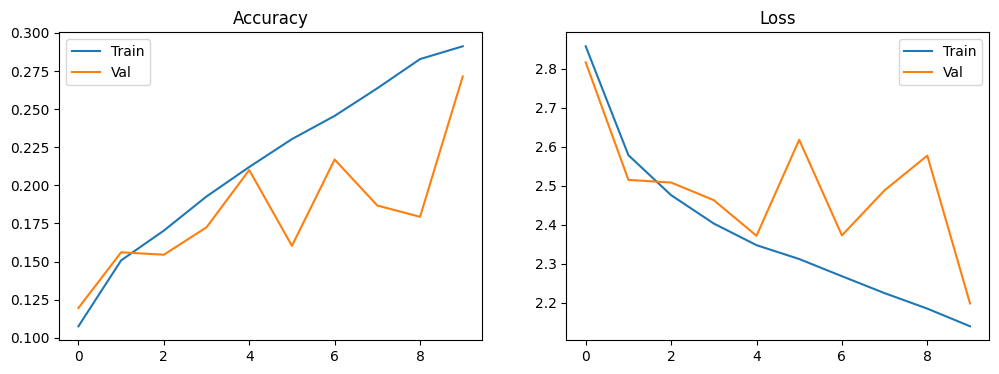

🏃 View run hyperaprameter tuning v1 at: https://dagshub.com/Arej02/Human_Action_Recognition.mlflow/#/experiments/1/runs/eb52bf8790d141fd847bc168601c5a16
🧪 View experiment at: https://dagshub.com/Arej02/Human_Action_Recognition.mlflow/#/experiments/1
Best configuration: {'hidden_nodes': 128, 'img_size': 64, 'batch_size': 16, 'learning_rate': 0.001}
Best accuracy: 0.2714


In [14]:
def main():
  best_config, best_accuracy = train_action_recognition()
  print(f"Best configuration: {best_config}")
  print(f"Best accuracy: {best_accuracy:.4f}")


if __name__ == "__main__":
    main()